In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib
import pickle
import random

# Paths
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\labels.csv"
MODEL_JOBLIB = r"C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.joblib"
MODEL_PICKLE = r"C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.pkl"

# HSV range for green detection
LOWER_HSV = np.array([70, 50, 50])
UPPER_HSV = np.array([90, 255, 255])

# Feature extraction
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_HSV, UPPER_HSV)
    height, width = mask.shape

    bands = [mask[int(height * 0.6):int(height * 0.7), :],
             mask[int(height * 0.7):int(height * 0.8), :],
             mask[int(height * 0.8):, :]]

    features = []
    for band in bands:
        indices = np.column_stack(np.where(band > 0))
        if indices.size > 0:
            avg_x = np.mean(indices[:, 1]) / width * 2 - 1
        else:
            avg_x = 0.0
        features.append(avg_x)

    return features

# Label binning logic
def label_to_bin(label):
    if label < -0.3:
        return 'left'
    elif label > 0.3:
        return 'right'
    else:
        return 'straight'

# Load CSV and normalize filenames
labels_df = pd.read_csv(LABEL_CSV)
labels_df['filename'] = labels_df['filename'].str.lower()
label_dict = dict(zip(labels_df['filename'], labels_df['Maneuvering']))

# Load and process images
binned_data = {'left': [], 'straight': [], 'right': []}
image_paths = sorted(glob(os.path.join(IMAGE_FOLDER, "*.png")))
skipped = 0

for img_path in tqdm(image_paths, desc="Extracting features"):
    filename = os.path.basename(img_path).lower()
    if filename not in label_dict:
        skipped += 1
        continue

    image = cv2.imread(img_path)
    if image is None:
        skipped += 1
        continue

    features = extract_features(image)
    label = label_dict[filename]
    bin_name = label_to_bin(label)
    binned_data[bin_name].append((features, label))

print(f"⚠️ Skipped {skipped} files due to missing labels or read issues.")

# Balance the dataset
min_count = min(len(binned_data['left']), len(binned_data['straight']), len(binned_data['right']))
if min_count == 0:
    raise ValueError("❌ One or more bins are empty. Cannot continue training.")

balanced_samples = []
for bin_name in binned_data:
    random.shuffle(binned_data[bin_name])
    balanced_samples.extend(binned_data[bin_name][:min_count])

random.shuffle(balanced_samples)

X = np.array([x for x, _ in balanced_samples])
y = np.array([y for _, y in balanced_samples])
bin_labels = [label_to_bin(val) for val in y]

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=bin_labels, random_state=42
)

# SVM pipeline
pipeline = make_pipeline(StandardScaler(), SVR())
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 0.2],
    'svr__kernel': ['rbf', 'poly']
}

# Train with hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Save the trained model
best_model = grid_search.best_estimator_
joblib.dump(best_model, MODEL_JOBLIB)
with open(MODEL_PICKLE, 'wb') as f:
    pickle.dump(best_model, f)

print("✅ Model training completed.")
print(f"📦 Model saved to: {MODEL_JOBLIB}")
print(f"📦 Also saved to: {MODEL_PICKLE}")
print(f"🔧 Best Parameters: {grid_search.best_params_}")


Extracting features: 100%|███████████████████████████████████████████████████████████| 977/977 [01:47<00:00,  9.13it/s]


⚠️ Skipped 0 files due to missing labels or read issues.
Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ Model training completed.
📦 Model saved to: C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.joblib
📦 Also saved to: C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.pkl
🔧 Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}


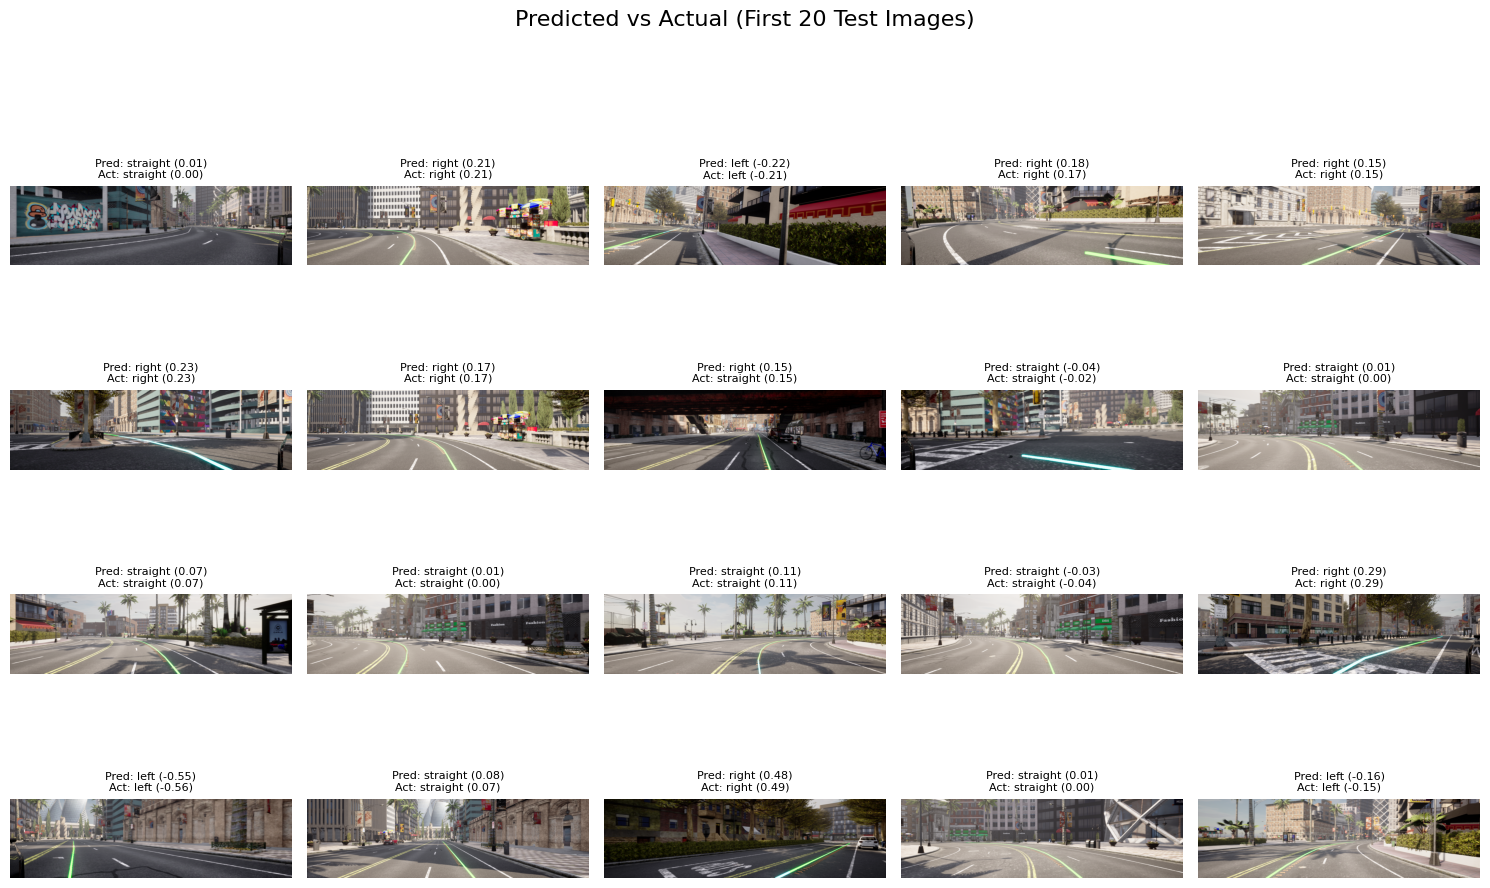


✅ Proportional Classification Accuracy (on all test data, ±0.15): 98.98%


<Figure size 600x500 with 0 Axes>

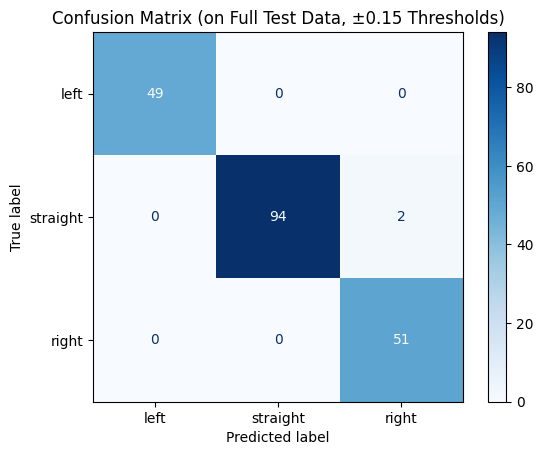

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
from glob import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# === Paths ===
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\labels.csv"
MODEL_PICKLE = r"C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.pkl"

# === Load label CSV ===
labels_df = pd.read_csv(LABEL_CSV)
labels_df['filename'] = labels_df['filename'].str.lower()
label_dict = dict(zip(labels_df['filename'], labels_df['Maneuvering']))

# === Load model from .pkl ===
with open(MODEL_PICKLE, "rb") as f:
    model = pickle.load(f)

# === HSV Range for Green Line ===
LOWER_HSV = np.array([70, 50, 50])
UPPER_HSV = np.array([90, 255, 255])

# === Feature Extraction Function ===
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_HSV, UPPER_HSV)
    height, width = mask.shape

    bands = [mask[int(height * 0.6):int(height * 0.7), :],
             mask[int(height * 0.7):int(height * 0.8), :],
             mask[int(height * 0.8):, :]]

    features = []
    for band in bands:
        indices = np.column_stack(np.where(band > 0))
        if indices.size > 0:
            avg_x = np.mean(indices[:, 1]) / width * 2 - 1
        else:
            avg_x = 0.0
        features.append(avg_x)

    return features

# === Proportional Logic (±0.15 thresholds) ===
def label_to_bin(value):
    if value < -0.15:
        return "left"
    elif value > 0.15:
        return "right"
    else:
        return "straight"

# === Load and prepare data ===
data = []
image_paths = sorted(glob(os.path.join(IMAGE_FOLDER, "*.png")))

for img_path in image_paths:
    filename = os.path.basename(img_path).lower()
    if filename not in label_dict:
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue

    features = extract_features(image)
    label = label_dict[filename]
    data.append((features, label, filename))

# === Shuffle and split ===
random.shuffle(data)
split_index = int(len(data) * 0.8)
test_data = data[split_index:]

# === Predict all test data ===
y_true, y_pred = [], []
y_true_bin, y_pred_bin = [], []

for features, true_val, fname in test_data:
    pred_val = model.predict([features])[0]
    true_bin = label_to_bin(true_val)
    pred_bin = label_to_bin(pred_val)

    y_true.append(true_val)
    y_pred.append(pred_val)
    y_true_bin.append(true_bin)
    y_pred_bin.append(pred_bin)

# === Display first 20 images in grid ===
grid_samples = test_data[:20]
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle("Predicted vs Actual (First 20 Test Images)", fontsize=16)

for idx, ax in enumerate(axes.flat):
    if idx >= len(grid_samples):
        ax.axis('off')
        continue

    features, true_val, fname = grid_samples[idx]
    pred_val = model.predict([features])[0]
    true_bin = label_to_bin(true_val)
    pred_bin = label_to_bin(pred_val)

    img = cv2.imread(os.path.join(IMAGE_FOLDER, fname))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title(f"Pred: {pred_bin} ({pred_val:.2f})\nAct: {true_bin} ({true_val:.2f})", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Accuracy for full test set ===
accuracy = accuracy_score(y_true_bin, y_pred_bin)
print(f"\n✅ Proportional Classification Accuracy (on all test data, ±0.15): {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true_bin, y_pred_bin, labels=["left", "straight", "right"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["left", "straight", "right"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (on Full Test Data, ±0.15 Thresholds)")
plt.show()


📤 Floating-point predictions on test images:

00432670.png → Predicted steering: 0.2304
00466249.png → Predicted steering: 0.0059
00466250.png → Predicted steering: -0.1639
00466291.png → Predicted steering: -0.0723
00868971.png → Predicted steering: 0.3217
00869214.png → Predicted steering: -0.0577
02178916.png → Predicted steering: 0.8056
02179648.png → Predicted steering: -0.7645
02183480.png → Predicted steering: 0.0867
02191443.png → Predicted steering: -0.2827
02194380.png → Predicted steering: -0.0276
02205026.png → Predicted steering: 0.3330
02207496.png → Predicted steering: -0.1755
02209156.png → Predicted steering: -0.8357
02219709.png → Predicted steering: -0.5397
02220002.png → Predicted steering: -0.0720
02228184.png → Predicted steering: 0.3108
02509860.png → Predicted steering: 0.4459
02511937.png → Predicted steering: -0.0454
02516117.png → Predicted steering: -0.6320
02518937.png → Predicted steering: 0.0414
02521267.png → Predicted steering: -0.5510
02524263.png → Pr

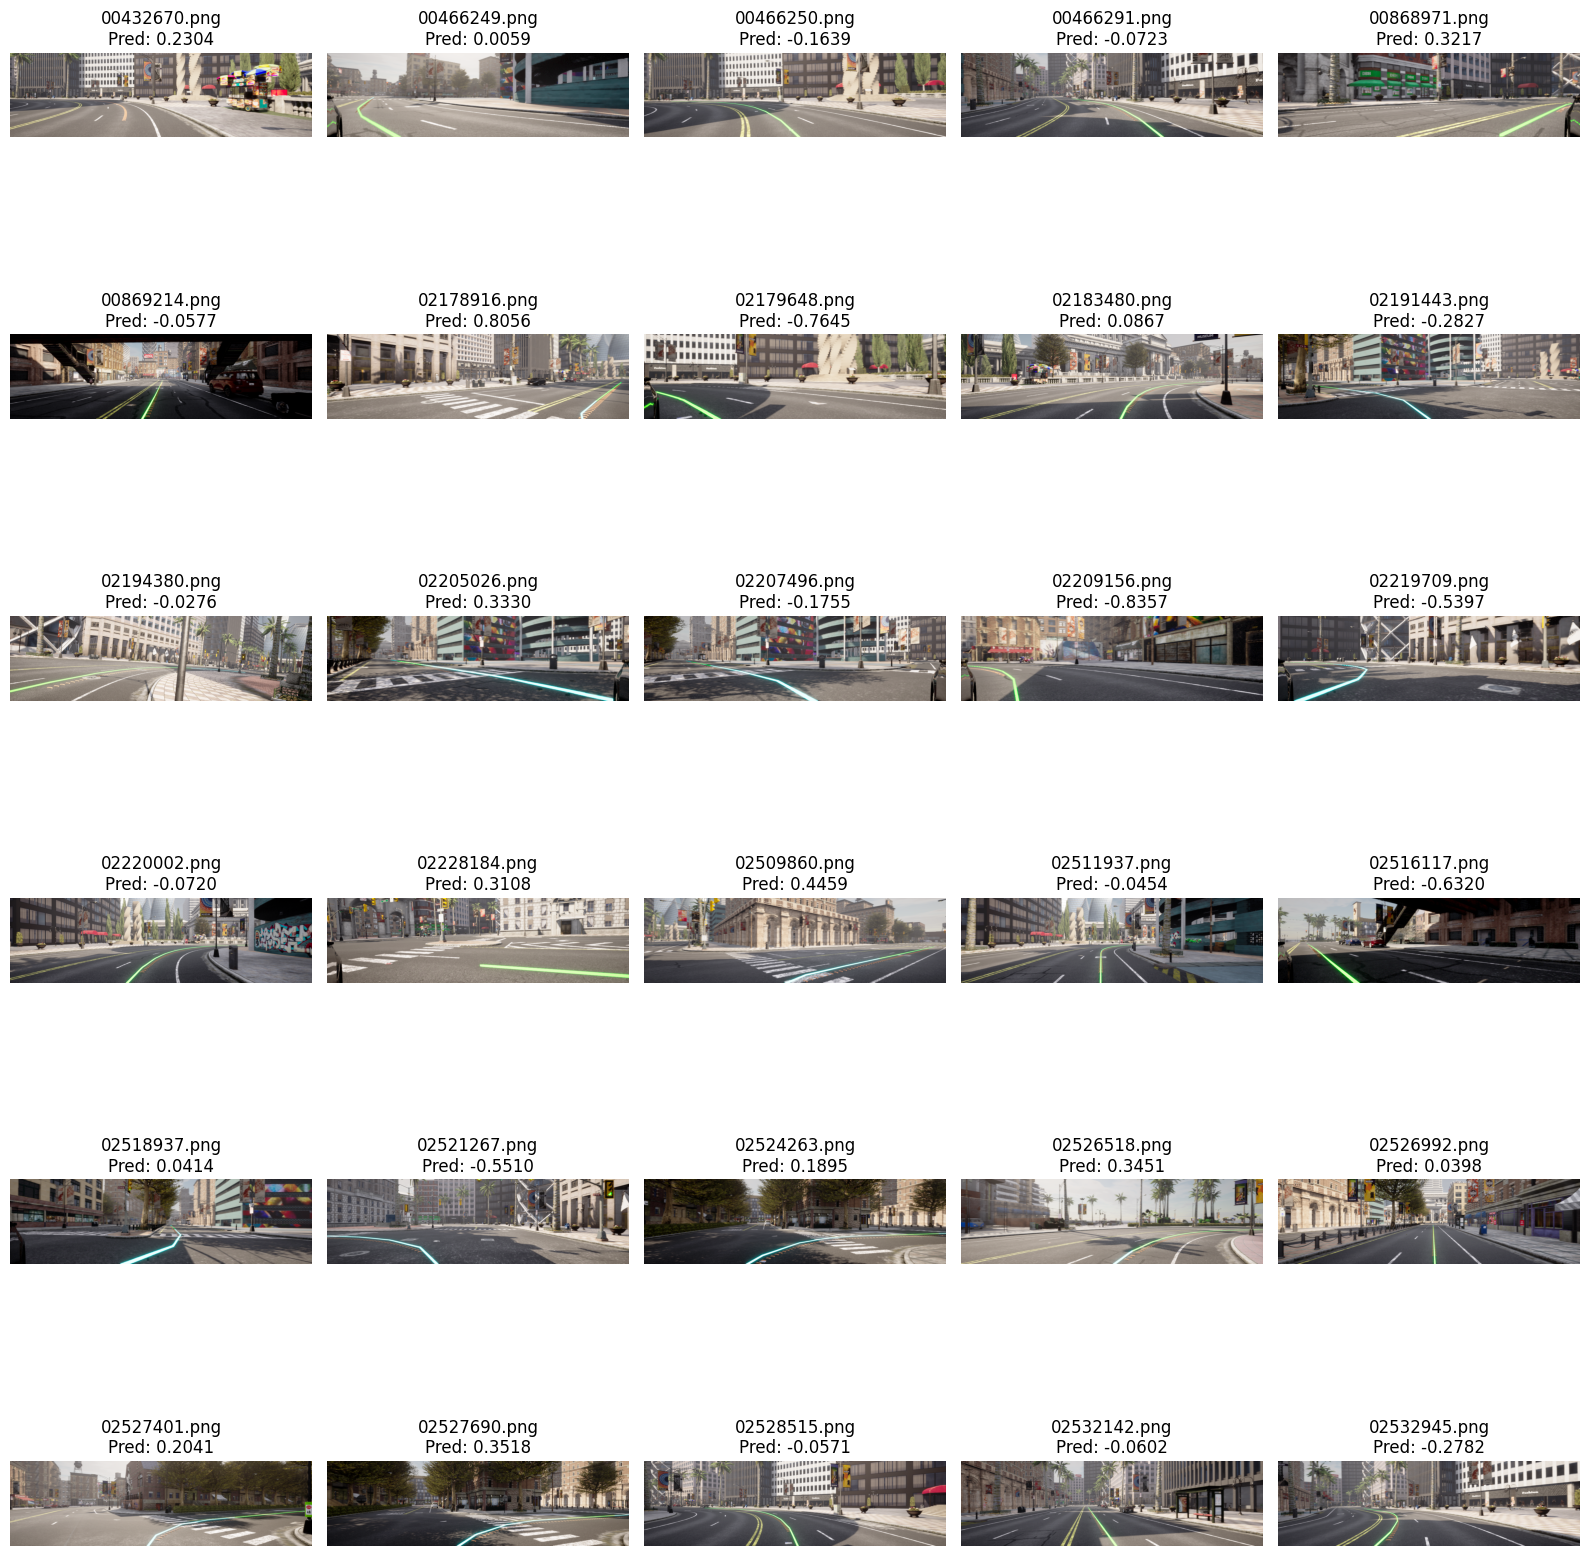

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from glob import glob

# === Paths ===
TEST_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\test"
MODEL_PICKLE = r"C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.pkl"

# === Load model from .pkl ===
with open(MODEL_PICKLE, "rb") as f:
    model = pickle.load(f)

# === HSV range for green detection ===
LOWER_HSV = np.array([70, 50, 50])
UPPER_HSV = np.array([90, 255, 255])

# === Feature extraction function ===
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_HSV, UPPER_HSV)
    height, width = mask.shape

    bands = [mask[int(height * 0.6):int(height * 0.7), :],
             mask[int(height * 0.7):int(height * 0.8), :],
             mask[int(height * 0.8):, :]]

    features = []
    for band in bands:
        indices = np.column_stack(np.where(band > 0))
        if indices.size > 0:
            avg_x = np.mean(indices[:, 1]) / width * 2 - 1
        else:
            avg_x = 0.0
        features.append(avg_x)

    return features

# === Load and predict ===
test_image_paths = sorted(glob(os.path.join(TEST_FOLDER, "*.png")))

print("📤 Floating-point predictions on test images:\n")
predictions = []
images_for_display = []

for path in test_image_paths:
    filename = os.path.basename(path)
    image = cv2.imread(path)
    if image is None:
        print(f"⚠️ Could not read: {filename}")
        continue

    features = extract_features(image)
    prediction = model.predict([features])[0]
    predictions.append([filename, round(float(prediction), 4)])

    print(f"{filename} → Predicted steering: {prediction:.4f}")
    images_for_display.append((cv2.cvtColor(image, cv2.COLOR_BGR2RGB), prediction, filename))

# === Save predictions to CSV ===
output_csv = os.path.join(TEST_FOLDER, "predictions.csv")
pd.DataFrame(predictions, columns=["filename", "predicted_maneuvering"]).to_csv(output_csv, index=False)
print(f"\n✅ Predictions saved to: {output_csv}")

# === Display images in grid with predictions ===
cols = 5
rows = int(np.ceil(len(images_for_display) / cols))
plt.figure(figsize=(16, rows * 3))

for idx, (img, pred, fname) in enumerate(images_for_display):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(f"{fname}\nPred: {pred:.4f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
